In [26]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

mpl.rcParams.update(params)


import warnings

warnings.filterwarnings("ignore")


In [27]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])

df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "view_count",
        "channel_id",
    ],
)


In [28]:
# round the subs value, easier to consider 1 sub as a person and not half of a person...
df_time_series.subs = df_time_series.subs.round(0)


In [29]:
df_time_series.head()


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.0,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.0,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1502.0,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.0,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.0,258.300000,6,0,0


In [30]:
df_channels.head()


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [31]:
video_metadatas.head()


,categories,upload_date,duration,like_count,view_count,channel_id
0,Film & Animation,2016-09-28,1159,8.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA
1,Film & Animation,2016-09-28,2681,23.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA
2,Film & Animation,2016-09-28,1394,1607.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA
3,Film & Animation,2016-09-28,5064,227.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA
4,Film & Animation,2016-09-28,3554,105.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA


# Check length of videos

An idea would be to use cut to match length of videos into discrete intervals 

In [32]:
video_metadatas.duration.describe()


count    7.292479e+07
mean     7.576761e+02
std      1.820111e+03
min      1.000000e+00
25%      1.340000e+02
50%      2.840000e+02
75%      6.980000e+02
max      3.601570e+05
Name: duration, dtype: float64

In [33]:
# To make it easier to grasp the length of videos, we will convert the lengths to minutes at first...
video_metadatas["duration_min"] = video_metadatas["duration"] / 60
video_metadatas.duration_min.describe()


count    7.292479e+07
mean     1.262794e+01
std      3.033518e+01
min      1.666667e-02
25%      2.233333e+00
50%      4.733333e+00
75%      1.163333e+01
max      6.002617e+03
Name: duration_min, dtype: float64

Text(0.5, 0, 'Duration in Minutes')

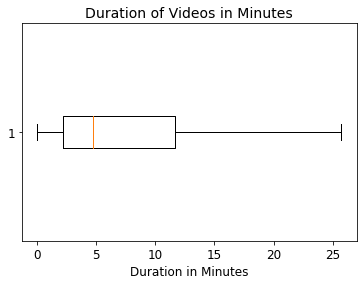

In [37]:
plt.boxplot(video_metadatas["duration_min"], showfliers=False, vert=False)
plt.title("Duration of Videos in Minutes")
plt.xlabel("Duration in Minutes")


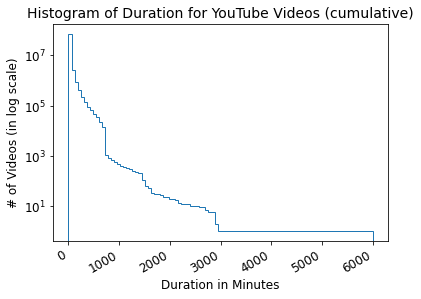

In [35]:
duration_min_cumul = plt.hist(
    video_metadatas.duration_min, bins=100, log=True, cumulative=-1, histtype="step"
)
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration in Minutes")
plt.xticks(rotation=30, ha="right")
plt.show()


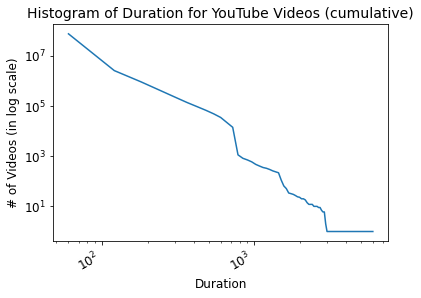

In [36]:
plt.loglog(duration_min_cumul[1][1:], duration_min_cumul[0])
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration")
plt.xticks(rotation=30, ha="right")
plt.show()


In [ ]:
# long to compute

# bucket_durations = pd.cut(video_metadatas['duration'], bins=100)
# print(type(bucket_durations))


---

# Check frequency of videos

In [38]:
video_count = (
    video_metadatas.groupby(pd.Grouper(key="upload_date", freq="W")).count().channel_id
)


Text(0.5, 1.0, 'Number of videos updated each week')

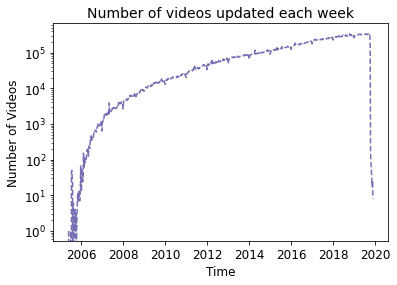

In [39]:
plt.plot(video_count, color="#7570b3", ls="--", label="\% videos uploaded")
plt.yscale("log")
plt.ylabel("Number of Videos")
plt.xlabel("Time")
plt.title("Number of videos updated each week")


In [134]:
# now we will determine how many videos are uploaded to YouTube by each channel by year
video_metadatas["yearkNumber"] = video_metadatas["upload_date"].dt.year
vd_cnt_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearkNumber"])
    .count().categories.unstack().reset_index()
)
vd_cnt_by_id_yr.columns.name = None

In [135]:
# we now remove the channels that uploaded less than 12 videos throughout the study period
vd_cnt_by_id_yr_filtered = vd_cnt_by_id_yr[vd_cnt_by_id_yr.sum(axis=1)>12]

In [136]:
vd_cnt_by_id_yr_filtered.head()

,channel_id,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,UC--24Q3_ZQeFmgJE-Um5QZQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,49.0,51.0,48.0,40.0
1,UC--2EbuIuBOGgGqPiJxi3rg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,24.0,13.0,8.0,3.0,3.0,1.0
2,UC--3c8RqSfAqYBdDjIG3UNA,NaN,NaN,NaN,24.0,37.0,17.0,NaN,8.0,12.0,7.0,21.0,11.0,66.0,66.0,64.0
3,UC--3ozenTzry39-xMqAPQlw,NaN,NaN,NaN,NaN,NaN,6.0,6.0,5.0,3.0,2.0,2.0,9.0,4.0,6.0,NaN
4,UC--6E6EpybocdaNlPhvK_9A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,11.0,2.0,3.0,2.0


In [148]:
vd_cnt_by_id_yr_filtered_summary = vd_cnt_by_id_yr_filtered.describe()

In [175]:
vd_cnt_by_id_yr_filtered_summary

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,33.000000,1885.000000,5155.000000,8947.000000,14727.000000,20938.000000,29325.000000,38601.00000,48677.000000,60123.000000,75091.000000,94368.000000,113922.000000,127458.000000,126167.000000
mean,10.060606,12.351724,26.623666,37.778697,47.155429,51.833986,63.933504,75.80757,82.542042,86.147265,90.654366,99.093241,109.575639,119.791884,100.755649
std,34.882785,34.539216,91.597818,148.152131,176.252079,173.637035,245.708965,291.72435,274.715330,297.807467,351.333804,382.779501,395.355451,522.820498,530.195955
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,6.00000,6.000000,7.000000,8.000000,10.000000,13.000000,13.000000,9.000000
50%,3.000000,4.000000,6.000000,9.000000,11.000000,13.000000,16.000000,19.00000,21.000000,22.000000,25.000000,30.000000,36.000000,36.000000,27.000000
75%,6.000000,11.000000,20.000000,27.000000,35.000000,41.000000,50.000000,59.00000,66.000000,68.000000,74.000000,82.000000,94.000000,96.000000,73.000000
max,203.000000,952.000000,2258.000000,7580.000000,8028.000000,9544.000000,12734.000000,19909.00000,15588.000000,24729.000000,48765.000000,39786.000000,28587.000000,46919.000000,45355.000000


Text(0.5, 1.0, 'The quantiles of yearly video upload frequency')

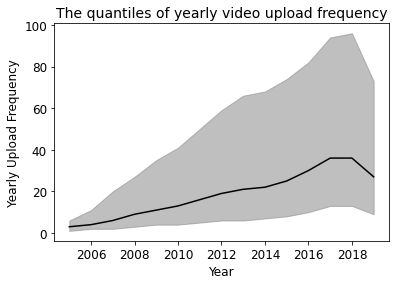

In [178]:
plt.fill_between(x=list(vd_cnt_by_id_yr_filtered_summary.columns.values),
                y1=list(vd_cnt_by_id_yr_filtered_summary.loc["25%",:]),
                y2=list(vd_cnt_by_id_yr_filtered_summary.loc["75%",:]), 
                 alpha = 0.5, color = 'gray')
plt.plot(vd_cnt_by_id_yr_filtered_summary.loc["50%",:], color = 'black')

plt.xlabel('Year')
plt.ylabel('Yearly Upload Frequency')
plt.title('The quantiles of yearly video upload frequency')
# here we choose quantiles, since mean would be significantly affected by the extremely high yearly upload rates

---

# How long to reach 1M subscribers 

Could be interesting to take all the videos with 10K, 20K, 30K, ... and see the evolution to reach 100K for example. And compare different evolution : from 50K to 100K or from 500K to 600K, etc.. which one is the fastest, easiest ?  

In [179]:
def get_df_channel_ascension(start_subs, end_subs):
    """finds the channels in the time series that have less than the start_subs and more than end_subs.
    It means that it begins with less than start_subs and have now at least end_subs

    Args:
        start_subs (float): low_threshold
        end_subs (float): high_threshold

    Returns:
        dataframe containing all the channels with evolution from starts_subs to end_subs
    """
    under_start_subs = df_time_series[df_time_series["subs"] < start_subs]
    more_end_subs = df_time_series[df_time_series["subs"] > end_subs]
    channel_start_to_end = df_time_series[
        df_time_series.channel.isin(under_start_subs.channel)
        & df_time_series.channel.isin(more_end_subs.channel)
    ]
    return channel_start_to_end


In [180]:
def get_mean_time_to_reach_X_subs(df, lower_bound, upper_bound):
    time_to_reach_X_subs = df.groupby("channel").apply(
        lambda group: pd.Series(
            {
                "from_zero_to_hero_duration": group[group.subs > upper_bound][
                    "datetime"
                ].iloc[0]
                - group[group.subs < lower_bound]["datetime"].iloc[-1]
            }
        )
    )
    return time_to_reach_X_subs


In [181]:
channel_10K_to_1M = get_df_channel_ascension(10_000, 1_000_000)
print(
    "We have {} channels that begins with 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)


We have 1252 channels that begins with 10K subs and reach at least 1M


There are 113 weeks for this channel
We should have approximately the same value : 
791 and 784 days 00:00:00


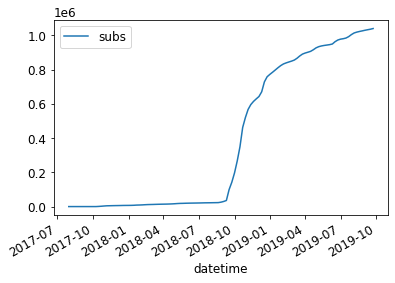

In [182]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)


In [183]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = get_mean_time_to_reach_X_subs(channel_10K_to_1M, 10_000, 1_000_000)
time_to_reach_1M.head()


,from_zero_to_hero_duration
channel,
UC-3fLOkTRb7-tepOqxsDdDg,97 days 23:00:00
UC-5Yj4HIiruwkzFuLflxL_w,574 days 01:00:00
UC-CSyyi47VX1lD9zyeABW3w,769 days 23:00:00
UC-HOjVdbw0TG6h44rH4Sirw,413 days 00:00:00
UC-LUjxkSJCxAMrZ4S0T3Drg,686 days 01:00:00


In [184]:
print(
    "In average YTbers take {} days to reach 1M of subscribers".format(
        time_to_reach_1M["from_zero_to_hero_duration"].mean().days
    )
)


In average YTbers take 511 days to reach 1M of subscribers


It would be nice to bootstrap this result to see with interval of confidence the time taken by Youtuber to reach 1M

In [185]:
data = time_to_reach_1M["from_zero_to_hero_duration"].apply(
    lambda delta_time: delta_time.days
)


In [186]:
rng = np.random.default_rng()
conf_interval_reach_1M = bootstrap(
    (data,),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
).confidence_interval
conf_interval_reach_1M


ConfidenceInterval(low=498.50026123894276, high=523.5420595613554)

In [187]:
print(
    "The 95% interval of confidence, the time taken to reach 1M (from 10K) is [{}, {}]".format(
        conf_interval_reach_1M.low, conf_interval_reach_1M.high
    )
)


The 95% interval of confidence, the time taken to reach 1M (from 10K) is [498.50026123894276, 523.5420595613554]


---

# Check the number of views (maybe after we could add likes, dislike) given a certain categories and date of videos

For this task lets analyze and after ploting and getting some intuition, use logistic regression to 'predict' the nb of views given category and date 

In [188]:
video_metadatas.head()
video_metadatas.shape


(72924794, 8)

In [189]:
# delete the rows with empty categories
videos_with_cat = video_metadatas
videos_with_cat.categories.replace("", np.nan, inplace=True)
videos_with_cat.dropna(subset=["categories"], inplace=True)
videos_with_cat.shape


(72923272, 8)

In [190]:
encoded_cat = pd.get_dummies(videos_with_cat.categories)
video_metadatas_encoded = videos_with_cat.join(encoded_cat)


In [191]:
video_metadatas_encoded["year"] = video_metadatas_encoded["upload_date"].dt.year


In [195]:
video_metadatas_encoded.head()


,categories,upload_date,duration,like_count,view_count,channel_id,duration_min,yearkNumber,Autos & Vehicles,Comedy,...,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Shows,Sports,Travel & Events,year
0,Film & Animation,2016-09-28,1159,8.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA,19.316667,2016,0,0,...,0,0,0,0,0,0,0,0,0,2016
1,Film & Animation,2016-09-28,2681,23.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA,44.683333,2016,0,0,...,0,0,0,0,0,0,0,0,0,2016
2,Film & Animation,2016-09-28,1394,1607.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA,23.233333,2016,0,0,...,0,0,0,0,0,0,0,0,0,2016
3,Film & Animation,2016-09-28,5064,227.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA,84.400000,2016,0,0,...,0,0,0,0,0,0,0,0,0,2016
4,Film & Animation,2016-09-28,3554,105.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA,59.233333,2016,0,0,...,0,0,0,0,0,0,0,0,0,2016


In [212]:
video_metadatas_encoded.columns

Index(['categories', 'upload_date', 'duration', 'like_count', 'view_count',
       'channel_id', 'duration_min', 'yearkNumber', 'Autos & Vehicles',
       'Comedy', 'Education', 'Entertainment', 'Film & Animation', 'Gaming',
       'Howto & Style', 'Movies', 'Music', 'News & Politics',
       'Nonprofits & Activism', 'People & Blogs', 'Pets & Animals',
       'Science & Technology', 'Shows', 'Sports', 'Travel & Events', 'year'],
      dtype='object')

In [213]:
# Wenxiu Comments: we probably should change the naming of columns - at least on my laptop the ones with & are not identified
model = smf.ols(
    formula='view_count ~ year + C(Autos & Vehicles) + C(Comedy) + C(Education) + C(Entertainment) + C(Film & Animation) + \
                C(Gaming) + C(Movies) + C(Music) + C(News & Politics) + C(Nonprofits & Activism) + \
                C(People & Blogs) + C(Pets & Animals) + C(Science & Technology) + C(Shows) + C(Sports) + C(Travel & Events)',
    data=video_metadatas_encoded
)

res = model.fit()
print(res.summary())


PatsyError: Error evaluating factor: NameError: name 'People' is not defined
    view_count ~ year + C(Autos & Vehicles) + C(Comedy) + C(Education) + C(Entertainment) + C(Film & Animation) +                 C(Gaming) + C(Movies) + C(Music) + C(News & Politics) + C(Nonprofits & Activism) +                 C(People & Blogs) + C(Pets & Animals) + C(Science & Technology) + C(Shows) + C(Sports) + C(Travel & Events)
                                                                                                                                                                                                                                     ^^^^^^^^^^^^^^^^^

---

In [214]:
top_ranked_channels = df_channels[df_channels.subscriber_rank_sb < 100]
top_ranked_channels.head()


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [215]:
date = top_ranked_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
np.mean(date, axis=0)


2010.3396226415093

In [216]:
oldest_video = df_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
oldest_video.nsmallest(5)


59578    2004.0
16       2005.0
40       2005.0
53       2005.0
54       2005.0
Name: join_date, dtype: float64

In [217]:
channels_with_largest_subscribers = df_channels.nlargest(53, "subscribers_cc")
channels_with_largest_subscribers.sample(7)


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
26,Entertainment,2012-02-20,UCX6OQ3DkcsbYNE6H8uQQuVA,MrBeast,24300000,709,54.0,2.087
10,Gaming,2015-04-06,UCEdvpU2pFRCVqU6yIPyTpMQ,Marshmello,39100000,366,18.0,2.087
28,Music,2012-11-22,UCOsyDsO5tIt-VZ1iwjdQmew,Speed Records,25502155,7451,59.0,2.087
23,Music,2014-10-29,UC22nIfOTM7KLIQuFGMKzQbg,Wave Music,27900000,18295,45.0,2.087
20,Music,2012-08-25,UCJrOtniJ0-NWz37R30urifQ,Alan Walker,29588818,198,39.0,2.087
55,Music,2006-03-13,UCq-Fj5jknLsUf-MWSy4_brA,T-Series,112139463,13839,102.0,2.087
38,Entertainment,2014-05-13,UCKqx9r4mrFglauNBJc1L_eg,[토이푸딩] ToyPu...,25600000,2851,80.0,2.087


In [ ]:
dfs = []

---

# Most common tags per category

(Paul) I will start this part when I find how to create videos metadata dataset with tags (& title)